# Out of Group Fish Predictions

From this thread: https://community.intuitivebayes.com/t/making-prediction-but-you-don-t-have-any-training-data-for-them/314

In [37]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Image

# import jupyter_black
# jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
# warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import simplefilter, warn

simplefilter("ignore")

In [38]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,5)
matplotlib.rcParams['figure.dpi'] = 120

In [39]:
fish_market = pd.read_csv("fish-market.csv")
fish_market.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [40]:
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()
fish_market.shape

(159, 9)

In [41]:
# original code 

# fish_test = fish_reduced.sample(frac=0.1, random_state=RANDOM_SEED).sort_index()
# test_idx = fish_test.index
# fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

# species_idx, species = fish_train.Species.factorize(sort=True)
# COORDS = {
#     "slopes": ["width_effect"],  # , "height_effect", "length_effect"],
#     "species": species,
# }

# COORDS

## Train/Test split > fish_test is Parkki, fish_train is all the rest 

In [42]:
fish_test = fish_reduced[fish_reduced['Species']=='Parkki'].sort_index()
test_idx = fish_test.index
fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

In [43]:
## Instead of factorize, we'll use pd.Categorical, which will allow us to add the out-of-sample category 
species_categorical = pd.Categorical(fish_train.Species, ordered=True)

# Add the out-of-sample category
species_categorical.add_categories('Parkki', inplace=True)

species = species_categorical.categories
species_idx =  species_categorical.codes
species_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [44]:
COORDS = {
    "slopes": ["width_effect"],  # , "height_effect", "length_effect"],
    "species": species,
}
COORDS

{'slopes': ['width_effect'],
 'species': Index(['Bream', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish', 'Parkki'], dtype='object')}

In [106]:
with pm.Model(coords=COORDS) as fish_hierarchical:
    # data
    log_width = pm.MutableData("log_width", fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.MutableData("species_idx", species_idx)
    
    
    # global priors for intercepts
    intercept_mu = pm.Normal("intercept_mu", sigma=3.0)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=1.0)

    # individual intercepts for each species
    intercept = pm.Normal(
        "intercept", mu=intercept_mu, sigma=intercept_sigma, dims="species"
    )
    
    
    β_mu = pm.Normal("β_mu", sigma=3.0)
    β_sigma = pm.HalfNormal("β_sigma", sigma=1.0)
    
    # individual betas for each species
    β = pm.Normal("β", mu=β_mu, sigma=β_sigma, dims="species")
    
    
    eps = pm.HalfNormal("eps", 1.0)
    mu = intercept[species_idx_] + β[species_idx_] * log_width
    
    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )
    
    # Manually add in hierarchical predictions
    hier_predictions = pm.Deterministic("hier_predictions", (β_mu*log_width + intercept_mu))
    
    
    idata_hierarchical = pm.sample(random_seed=RANDOM_SEED, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, intercept, β_mu, β_sigma, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## Hierarchical Parameters

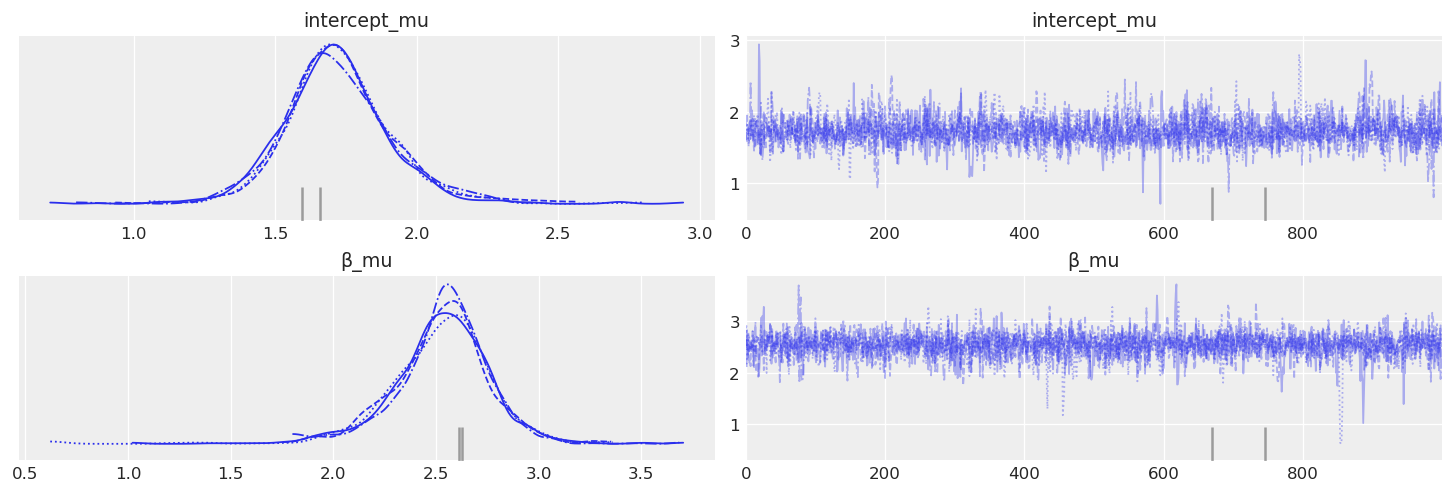

In [46]:
az.plot_trace(idata_hierarchical, var_names=["intercept_mu", "β_mu"]);

In [47]:
az.summary(idata_hierarchical)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_mu,1.722,0.192,1.379,2.090,0.004,0.003,2214.0,1753.0,1.00
intercept[Bream],1.944,0.267,1.456,2.453,0.006,0.004,1955.0,2341.0,1.00
intercept[Perch],1.373,0.090,1.199,1.538,0.002,0.001,2405.0,2294.0,1.00
intercept[Pike],1.799,0.235,1.375,2.263,0.005,0.003,2356.0,2117.0,1.00
intercept[Roach],1.596,0.200,1.235,1.985,0.004,0.003,2356.0,2487.0,1.00
intercept[Smelt],1.842,0.089,1.688,2.017,0.002,0.002,1704.0,2018.0,1.00
intercept[Whitefish],1.817,0.302,1.279,2.408,0.007,0.005,2188.0,2184.0,1.00
intercept[Parkki],1.705,0.428,0.958,2.568,0.008,0.006,3050.0,1972.0,1.00
β_mu,2.528,0.238,2.072,2.949,0.005,0.004,2576.0,2016.0,1.00
β[Bream],2.626,0.158,2.319,2.911,0.004,0.003,1923.0,2261.0,1.00


In [48]:
# added 
with fish_hierarchical:
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

In [49]:
fish_train.shape

(147, 9)

In [50]:
idata_hierarchical.posterior_predictive['log_obs'].shape

(4, 1000, 147)

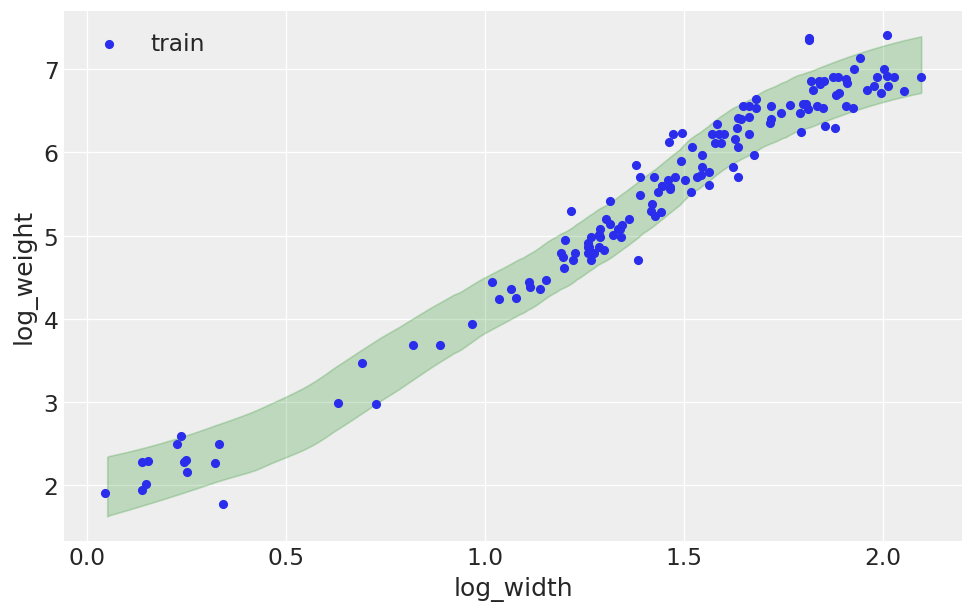

In [51]:
fig, ax = plt.subplots()
az.plot_hdi(fish_train['log_width'], idata_hierarchical.posterior_predictive["log_obs"],
    hdi_prob=.95, ax=ax, color='green', fill_kwargs={"alpha": .2})
fish_train.plot(x="log_width", y="log_weight", kind="scatter", ax=ax, c="C0", label="train",s=20);

# Out of Sample Fish Predictions - for out-of-sample group Parkki

In [52]:
species_categorical

['Bream', 'Bream', 'Bream', 'Bream', 'Bream', ..., 'Smelt', 'Smelt', 'Smelt', 'Smelt', 'Smelt']
Length: 147
Categories (7, object): ['Bream' < 'Perch' < 'Pike' < 'Roach' < 'Smelt' < 'Whitefish' < 'Parkki']

In [53]:
# Total number of categories 
len(species_categorical.categories)

7

In [54]:
# Get the out-of-sample category code > it's one more than the max in species_categorical.codes
oos_catcode = np.max(species_categorical.codes) + 1
oos_catcode

6

In [55]:
# Create array of category codes for new category, length is the size of the test dataset
species_idx_test = np.full(fish_test.shape[0], oos_catcode)
species_idx_test

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [107]:
# Update our mutable data 
with fish_hierarchical:
    pm.set_data(
        {
            "log_width": fish_test.log_width.values,
            "species_idx": species_idx_test
        }
    )

In [108]:
# Get our predictions on the test data 
with fish_hierarchical:
    idata_hierarchical_ppc = pm.sample_posterior_predictive(
        idata_hierarchical,
        predictions=True,
        extend_inferencedata=False,
        var_names=["hier_predictions", "hier_predictions_eps", "log_obs"]
    )

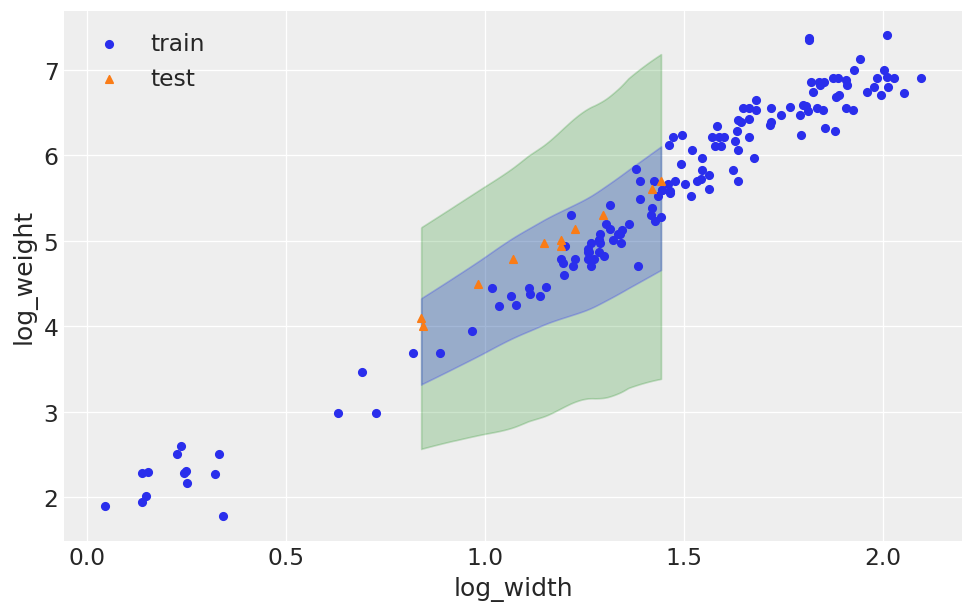

In [111]:
fig, ax = plt.subplots()

az.plot_hdi(fish_test['log_width'], idata_hierarchical_ppc.predictions["log_obs"],
    hdi_prob=.95, ax=ax, color='green', fill_kwargs={"alpha": .2})

# Ravin added this
az.plot_hdi(fish_test['log_width'], idata_hierarchical_ppc.predictions["hier_predictions"],
    hdi_prob=.95, ax=ax, color='blue', fill_kwargs={"alpha": .2})


fish_train.plot(x="log_width", y="log_weight", kind="scatter", ax=ax, c="C0", label="train",s=20);
fish_test.plot(x="log_width", y="log_weight", kind="scatter", ax=ax, c="C1", label="test", marker="^", s=20);

In [60]:
idata_hierarchical.predictions

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 1000, log_obs_dim_0: 11)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * log_obs_dim_0  (log_obs_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    log_obs        (chain, draw, log_obs_dim_0) float64 4.091 3.96 ... 4.735
Attributes:
    created_at:                 2022-07-23T01:49:55.983316
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.0

<AxesSubplot:>

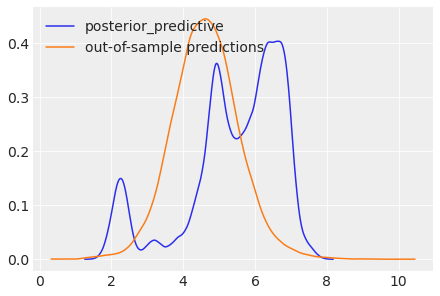

In [24]:
az.plot_dist(idata_hierarchical.posterior_predictive["log_obs"], color='C0', label='posterior_predictive')
az.plot_dist(idata_hierarchical.predictions["log_obs"], color='C1', label = 'out-of-sample predictions')

# Wow - why so much uncertainty for predictions? Is this correct? 

## Ravins Code

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

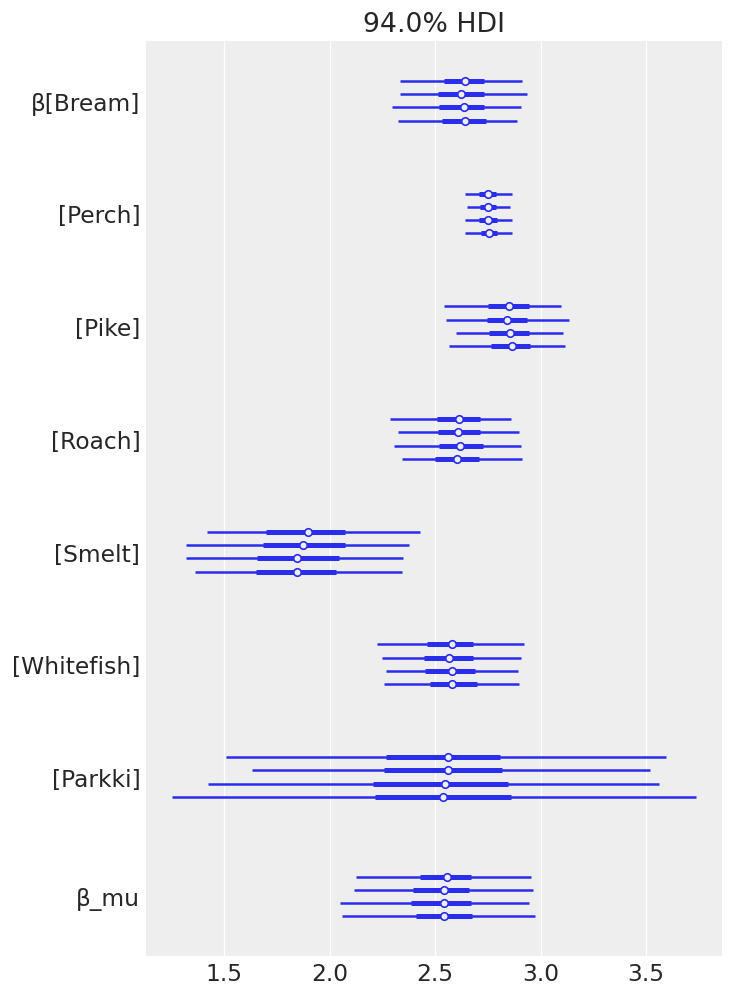

In [89]:
az.plot_forest(idata_hierarchical, var_names=["β", "β_mu"])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

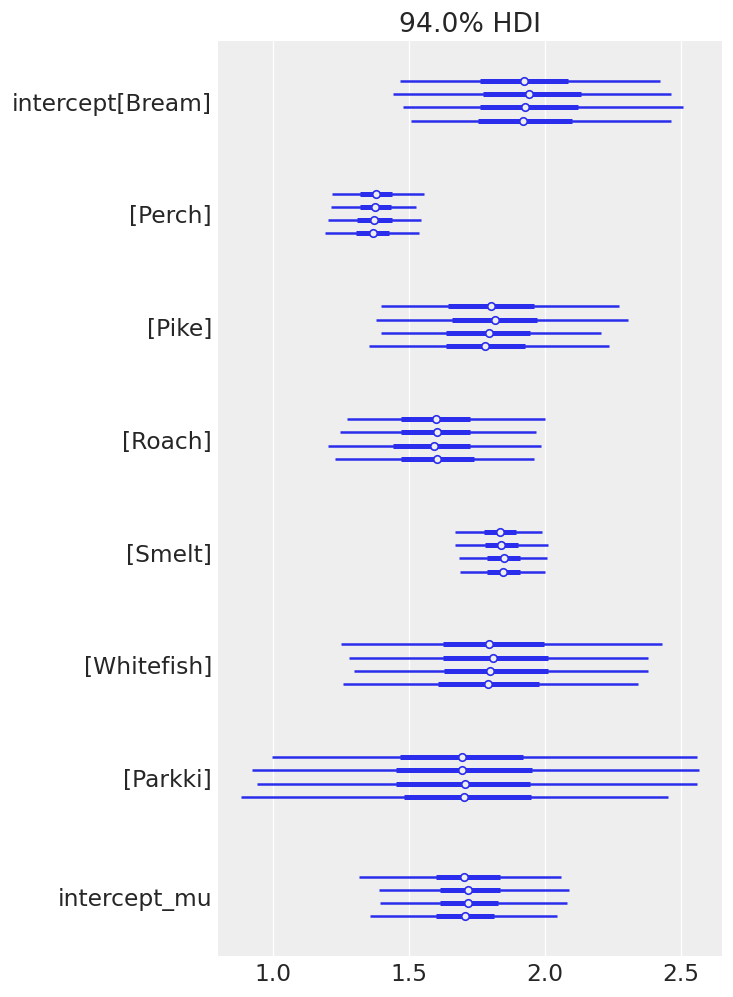

In [90]:
az.plot_forest(idata_hierarchical, var_names=["intercept", "intercept_mu"])

In [91]:
# Get our predictions on the test data 
with fish_hierarchical:
    idata_hierarchical_manual = pm.sample_posterior_predictive(
        idata_hierarchical,
        predictions=True,
        extend_inferencedata=False,
        var_names = ["hier_predictions"]
    )

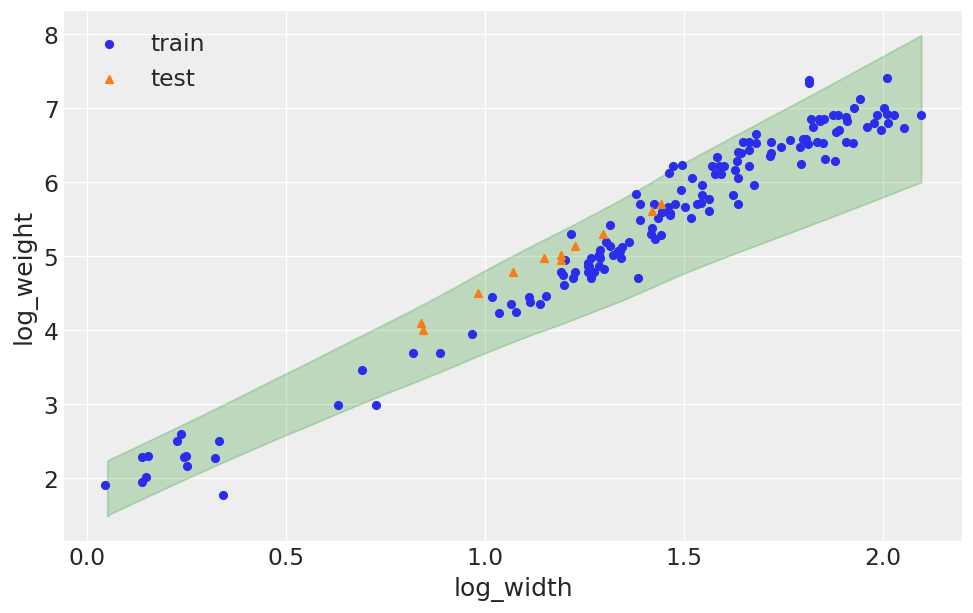

In [92]:
fig, ax = plt.subplots()

az.plot_hdi(fish_train['log_width'], idata_hierarchical_manual.predictions["hier_predictions"],
    hdi_prob=.95, ax=ax, color='green', fill_kwargs={"alpha": .2})

fish_train.plot(x="log_width", y="log_weight", kind="scatter", ax=ax, c="C0", label="train",s=20);
fish_test.plot(x="log_width", y="log_weight", kind="scatter", ax=ax, c="C1", label="test", marker="^", s=20);

### New Code

In [27]:
# Get our predictions on the test data 
with fish_hierarchical:
    idata_hierarchical = pm.sample_posterior_predictive(
        idata_hierarchical,
        var_names = ["β_mu", ""]
        predictions=True,
        extend_inferencedata=True
    )

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 1000, log_obs_dim_0: 147)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * log_obs_dim_0  (log_obs_dim_0) int64 0 1 2 3 4 5 ... 141 142 143 144 145 146
Data variables:
    log_obs        (chain, draw, log_obs_dim_0) float64 5.863 5.82 ... 2.985
Attributes:
    created_at:                 2022-07-23T01:35:50.740872
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.0

# Below is the original code

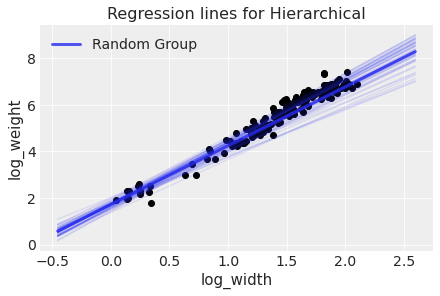

In [25]:
def plot_pred_out_of_sample(idata,  color="0.5", label="", ax=None):
    """
    Helper function to plot regression lines from the posterior on top of data points.
    """
    
    # Let's just pick one specicies for the x bounds but thats it
    species="Whitefish"
#     fish_spec = fish_reduced[fish_reduced.Species == species]

    # Plot all fish data
    fish_spec = fish_reduced
    x_lower = fish_spec["log_width"].min() - 0.5
    x_upper = fish_spec["log_width"].max() + 0.5
    x = np.linspace(x_lower, x_upper, 150)

    ys = []
    
    # This is changed to out of sample
    if ax is None:
        fig, ax = plt.subplots()
        
        # Plot the scatter of all fish
        ax.scatter(fish_spec["log_width"], fish_spec["log_weight"], color="k")

    # Replace these with hierarchical Parameters intercept_mu, β_mu
    y = idata.posterior["intercept_mu"].mean(
        ("chain", "draw")
    ).data + (
        x * idata.posterior["β_mu"].mean(("chain", "draw")).data
    )
    ax.plot(x, y, color=color, alpha=0.8, lw=3, label=label)

    # Changed the parameters we used here as well
    for count, i in enumerate(range(100, 150)):
        y = idata.posterior["intercept_mu"].sel(chain=0, draw=i).data + (
            x * idata.posterior["β_mu"].sel(chain=0, draw=i).data
        )
        ys.append(y)
        ax.plot(x, y, color=color, alpha=0.1)

    ax.set(
        xlabel="log_width", ylabel="log_weight", title=f"Regression lines for Hierarchical"
    )

    if label != "":
        ax.legend()

    return ax

plot_pred_out_of_sample(idata_hierarchical, label="Random Group", color=sns.color_palette()[0]);